# Computational & Deep Learning Frameworks Benchmark on real-world tasks

Frameworks compared:
* [Python 3](https://www.python.org/)/[Numpy](http://www.numpy.org/) with or without [Numba JIT compilation](http://numba.pydata.org/)
* [Julia](https://julialang.org/) The Julia Programming Language
* C++ called from Python using [pybind11](https://github.com/pybind/pybind11)
* [Tensorflow](https://www.tensorflow.org) v1 in CPU/GPU mode
* [Theano](http://deeplearning.net/software/theano)
* [MinPy](https://github.com/dmlc/minpy) a NumPy interface above [MXNet](http://mxnet.io) backend, in CPU/GPU mode
* [Gluon](https://gluon.mxnet.io/) library in Apache [MXNet](http://mxnet.io), CPU/GPU mode
* [CuPy](https://cupy.chainer.org/) an open-source matrix library accelerated with NVIDIA CUDA.
* [R](https://www.r-project.org/) Project for Statistical Computing

Single precision float numbers are used when possible. R works with double precision. 

In [1]:
!python3 --version
!Rscript --version
!julia --version
!pip list --format freeze | grep "numpy\|tensorflow\|Theano\|numba\|minpy\|mxnet\|cupy"

Python 3.8.2
R scripting front-end version 3.6.3 (2020-02-29)
julia version 1.6.0-DEV
cupy-cuda102==7.5.0
minpy==0.3.4
numba==0.49.1
numpy==1.17.4
numpydoc==0.9.2
tensorflow==1.15.3
tensorflow-estimator==1.15.1
Theano==1.0.4+51.gf1e4ec47c


In [2]:
import os
import subprocess
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from subprocess import Popen, PIPE
import re
import matplotlib

%matplotlib inline

In [3]:
# define utility functions

def get_json(x):
    return re.match("^[^\{]*(\{[^\}]+\})[^}]*$", x.decode()).group(1)

def get_exec(file_name):
    for ext, exe in {'.py': 'python3', '.jl': 'julia', '.R': 'Rscript'}.items():
        if file_name.endswith(ext):
            return exe

def exe(file_name, mode, cwd, **kwargs):
    p = Popen([get_exec(file_name), version, '-mode', mode], stdout=PIPE, stderr=PIPE, cwd=cwd)        
    output, err = p.communicate()
    if p.returncode==0:
        try:
            json_str = get_json(output)
            result_json = json.loads(json_str)
            print(result_json)
            return result_json
        except Exception as e:
            print("Exception in benchmark", e, str(json_str))
    else:
        print("Benchmark failed, check program output:", err)
        
def exe(file_name, mode, cwd='', **kwargs):
    args = sum([[f'-{k}', f'{v}'] for k, v in kwargs.items()], [get_exec(file_name), version, '-mode', mode])
    p = Popen(args, stdout=PIPE, stderr=PIPE, cwd=cwd)        
    output, err = p.communicate()
    if p.returncode==0:
        try:
            json_str = get_json(output)
            result_json = json.loads(json_str)
            print(result_json)
            return result_json
        except Exception as e:
            print("Exception in benchmark", e, str(json_str))
    else:
        print("Benchmark failed, check program output:", err)

## Task I: Time-series model (*Scan* operation  benchmark)
We estimate Log-Likelihood of GARCH (Generalized Autoregressive Conditional Heteroscedasticity) model, this is an econometric model used for modeling and forecasting time-dependent variance. Parameters in GARCH models are usually determined by Maximum Likelihood Estimation.
The main part of the calculation involves scan over the time-series ɛ² using the next equation (α, β and ω are model parameters):
    $$h[i] = ω + α*ɛ²[i-1] + β*h[i-1]$$
### References:
T. Bollerslev (1986): Generalized Autoregressive Conditional Heteroscedasticity. Journal of Econometrics 31, 307–327.
https://github.com/AndreyKolev/GARCH.jl - Julia library for GARCH modeling.

### Comments:
**It's a very small-scale sequential task, so we are not expecting great numbers from gpu versions. Large scale version of the task will be realeased later.**
For Theano and Tensorflow frameworks we also perform the loop unrolling to evaluate efficiency of the built-in scan operations



In [4]:
results = {}
results['garch'] = {}

n = 1000
versions = {'garch.py': ['std', 'numba', 'c++'],
            'garch-minpy.py': ['cpu', 'gpu'],
            'garch-gluon.py': ['cpu', 'gpu'],
            'garch-cupy.py': ['std'],
            'garch-theano.py': ['cpu', 'gpu'],
            'garch-tf.py': ['cpu', 'gpu'],
            'garch.jl': ['std'],
            'garch.R': ['reduce']}

for version, modes in versions.items(): 
    for mode in modes:
        print(version, 'mode:', mode)
        result_json = exe(version, mode, './garch/', n=n)
        if result_json is not None:
            results['garch'].update(result_json)

garch.py mode: std
{'numpy-std': 0.39001482000458054}
garch.py mode: numba
{'numpy-numba': 0.003971405996708199}
garch.py mode: c++
{'c++': 0.003881319993524812}
garch-minpy.py mode: cpu
{'minpy-cpu': 55.36055296601262}
garch-minpy.py mode: gpu
{'minpy-gpu': 51.24695117100782}
garch-gluon.py mode: cpu
{'gluon-cpu': 129.54008288499608}
garch-gluon.py mode: gpu
{'gluon-gpu': 112.78388043701125}
garch-cupy.py mode: std
{'cupy': 24.10497034099535}
garch-theano.py mode: cpu
{'theano-cpu': 0.7732547500054352, 'theano-unroll-cpu': 0.1466885209956672}
garch-theano.py mode: gpu
{'theano-gpu': 5.000846328999614, 'theano-unroll-gpu': 4.749561093005468}
garch-tf.py mode: cpu
{'tensorflow-cpu': 17.68395295299706, 'tensorflow-cpu-unroll': 4.88724617700791}
garch-tf.py mode: gpu
{'tensorflow-gpu': 82.51880456900108, 'tensorflow-gpu-unroll': 15.920211368007585}
garch.jl mode: std
{'julia': 0.00669319}
garch.R mode: reduce
{'R-reduce': 0.429393529891968}


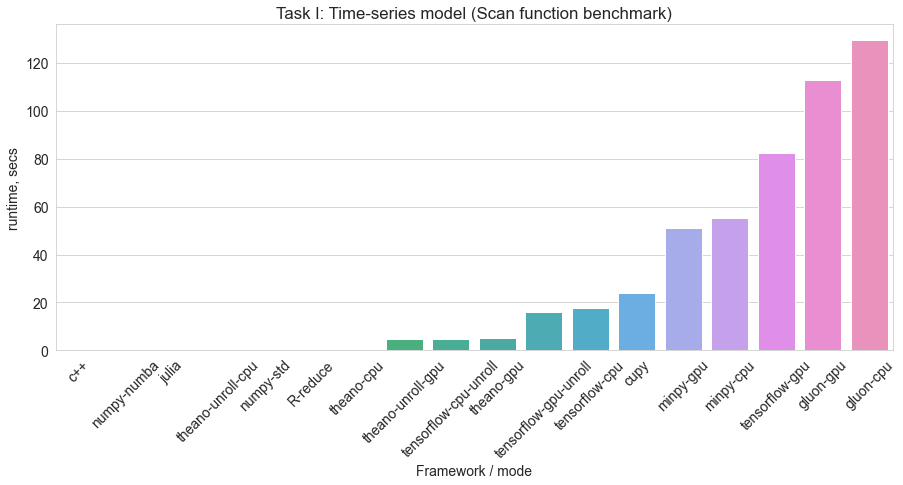

In [5]:
def plot_results(results, title, topn=None):
    sns.set_style("whitegrid")
    sns.mpl.rcParams['figure.figsize'] = (15, 6)
    sns.mpl.rcParams['font.size'] = 14
    plt.xticks(rotation=45)
    results_sorted = sorted(results.items(), key=lambda x: x[1])
    if topn is None:
        plot = sns.barplot([x[0] for x in results_sorted], [x[1] for x in results_sorted])
    else:
        plot = sns.barplot([x[0] for x in results_sorted[:topn]], [x[1] for x in results_sorted[:topn]])
    plot.set_title(title)
    plot.set(xlabel='Framework / mode', ylabel='runtime, secs');

plot_results(results['garch'], 'Task I: Time-series model (Scan function benchmark)')

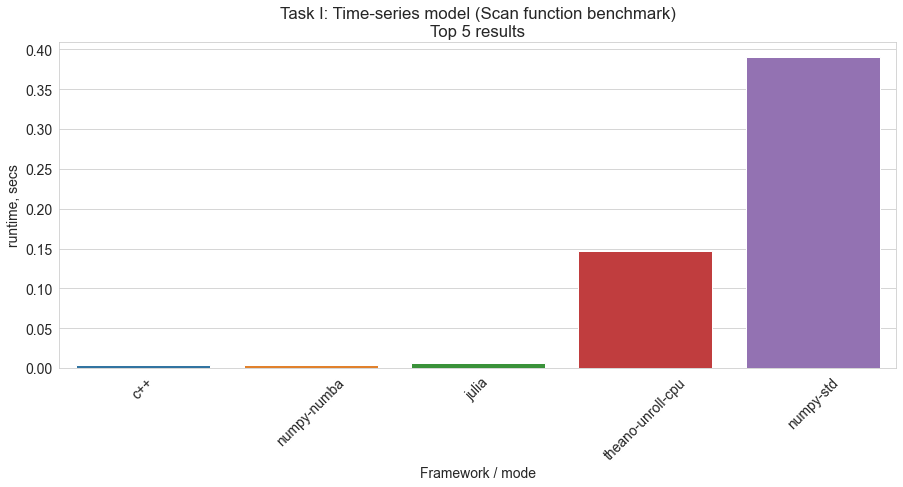

In [6]:
plot_results(results['garch'], 'Task I: Time-series model (Scan function benchmark)\nTop 5 results', 5)

## Task II - Monte Carlo simulation
We use MC simulation to calculate the price of the [Barrier Option](https://en.wikipedia.org/wiki/Barrier_option)

Geometric Brownian motion is used to model stock prices

In [7]:
results['mc'] = {}
            
versions = {'mc.py': ['std', 'multiprocessing', 'numba', 'c++', 'c++-parallel'],
           'mc.jl': ['std', 'parallel', 'matrix'],
           'mc-theano.py': ['cpu', 'gpu'],
           'mc-tf.py': ['cpu', 'gpu'],
           'mc-minpy.py': ['cpu', 'gpu'],
           'mc-gluon.py': ['cpu', 'gpu'],
           'mc-cupy.py': ['std'],
           'mc.R': ['std', 'parallel']}

for version, modes in versions.items(): 
    for mode in modes:
        print(version, 'mode:', mode)
        result_json = exe(version, mode, './mc/')
        if result_json is not None:
            results['mc'].update(result_json)

mc.py mode: std
{'numpy-std': 4.679629523001495}
mc.py mode: multiprocessing
{'numpy-multiprocessing': 1.4430469219951192}
mc.py mode: numba
{'numpy-numba': 4.787812053997186}
mc.py mode: c++
{'c++': 3.685793118987931}
mc.py mode: c++-parallel
{'c++-parallel': 0.471149537988822}
mc.jl mode: std
{'julia-std': 3.267075996}
mc.jl mode: parallel
{'julia-parallel': 0.467063911}
mc.jl mode: matrix
{'julia-matrix': 3.522042758}
mc-theano.py mode: cpu
{'theano-cpu': 4.877840273999027}
mc-theano.py mode: gpu
{'theano-gpu': 4.60206640099932}
mc-tf.py mode: cpu
{'tensorflow-cpu': 3.410978009007522}
mc-tf.py mode: gpu
{'tensorflow-gpu': 0.12555977299052756}
mc-minpy.py mode: cpu
{'minpy-cpu': 2.226063605994568}
mc-minpy.py mode: gpu
{'minpy-gpu': 0.2521144829952391}
mc-gluon.py mode: cpu
{'gluon-cpu': 2.083141021998017}
mc-gluon.py mode: gpu
{'gluon-gpu': 0.12277296200045384}
mc-cupy.py mode: std
{'cupy': 0.2287152879871428}
mc.R mode: std
{'R-std': 9.64920735359192}
mc.R mode: parallel
{'R-parall

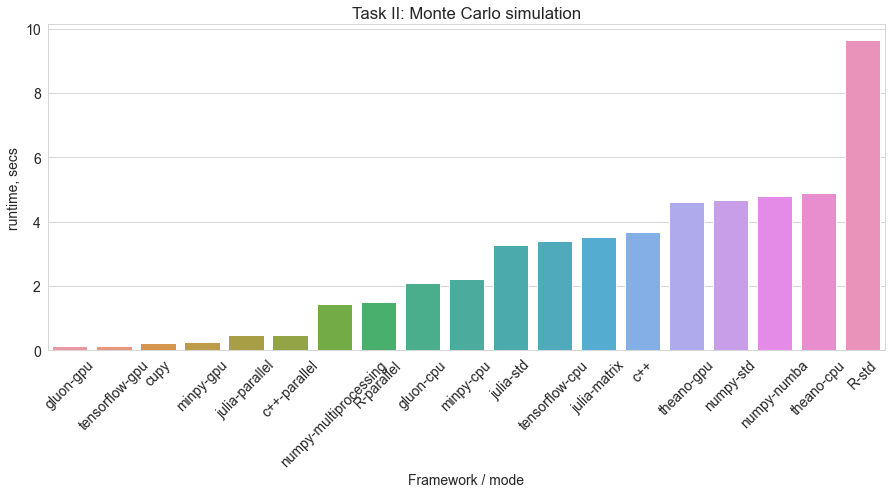

In [8]:
plot_results(results['mc'], 'Task II: Monte Carlo simulation')

### Task III: Logistic regression using [Hybrid Monte Carlo (HMC)](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo)

Dataset: [UCI/Adult](https://archive.ics.uci.edu/ml/datasets/Adult), # of classes: 2, # of data: 32,561/16,281 (testing), # of features: 123

In [9]:
results['hmc'] = {}
versions = {'hmc-tf.py': ['cpu', 'gpu'],
            'hmc-theano.py': ['cpu', 'gpu'],
            'hmc-cupy.py': ['std'],
            'hmc.py': ['std'],
            'hmc.jl': ['std'],
            'hmc.R': ['std']}

for version, modes in versions.items(): 
    for mode in modes:
        print(version, 'mode:', mode)
        result_json = exe(version, mode, './hmc/')
        if result_json is not None:
            results['hmc'].update(result_json)

hmc-tf.py mode: cpu
{'tensorflow-cpu': 119.69875015699654}
hmc-tf.py mode: gpu
{'tensorflow-gpu': 23.149858559001586}
hmc-theano.py mode: cpu
{'theano-cpu': 191.66669057600666}
hmc-theano.py mode: gpu
{'theano-gpu': 23.12248755300243}
hmc-cupy.py mode: std
{'cupy': 31.776003459002823}
hmc.py mode: std
{'numpy-std': 141.86269849300152}
hmc.jl mode: std
{'julia': 210.38856201}
hmc.R mode: std
{'R': 3437.24803614616}


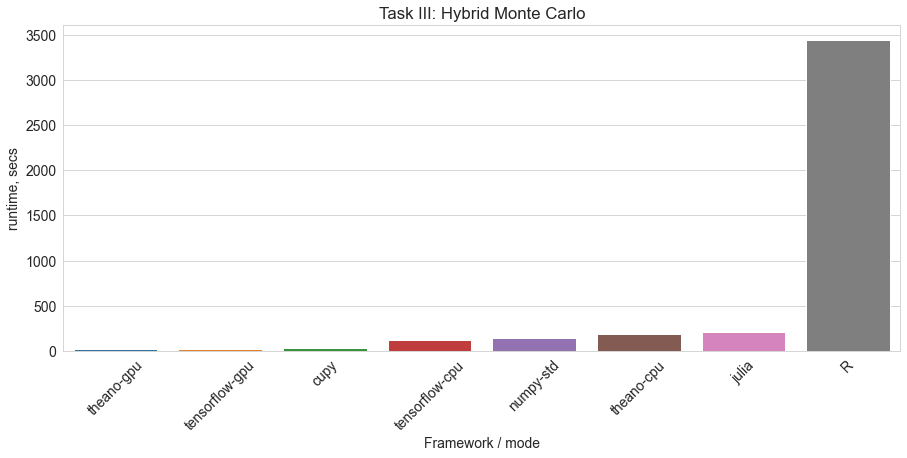

In [10]:
plot_results(results['hmc'], 'Task III: Hybrid Monte Carlo')